<a href="https://colab.research.google.com/github/Arrheniuss/Heart_Disease_Classification_Using_Machine_Learning/blob/main/Heart_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
#pip install catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [ ]:
def remove_outliers_column(df, column):
    # Obliczanie kwartyliw i IQR dla określonej kolumny
    Q1 = df[column].quantile(0.25)  # Pierwszy kwartyl (Q1)
    Q3 = df[column].quantile(0.75)  # Trzeci kwartyl (Q3)
    IQR = Q3 - Q1  # Rozstęp międzykwartylowy (IQR)

    # Definiowanie dolnej i górnej granicy
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Użycie Series.clip do ograniczenia wartości do zakresu
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

In [ ]:
# Funkcja zbierajaca wyniki modelu
def update_results(model_name, model, X_train, y_train, X_test, y_test):
    # Trenowanie modelu
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Obliczanie metryk
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # AUC tylko, jeśli model ma predict_proba
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_curves[model_name] = (fpr, tpr)
    else:
        roc_auc = None

    # Dodanie wyników do słownika
    metrics_results['model'].append(model_name)
    metrics_results['accuracy'].append(accuracy)
    metrics_results['precision'].append(precision)
    metrics_results['recall'].append(recall)
    metrics_results['f1'].append(f1)
    metrics_results['roc_auc'].append(roc_auc)

In [ ]:
# Inicjalizacja słownika do przechowywania wyników
metrics_results = {
    'model': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

roc_curves = {}

In [ ]:
df = pd.read_csv('heart.csv')
df_original = df.copy()

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


In [ ]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [ ]:
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [ ]:
print((df == 0).sum())

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS         704
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak           368
ST_Slope            0
HeartDisease      410
dtype: int64


Wykresy z wartosciamy odstajacymi przed scieciem wartosci odstajacych


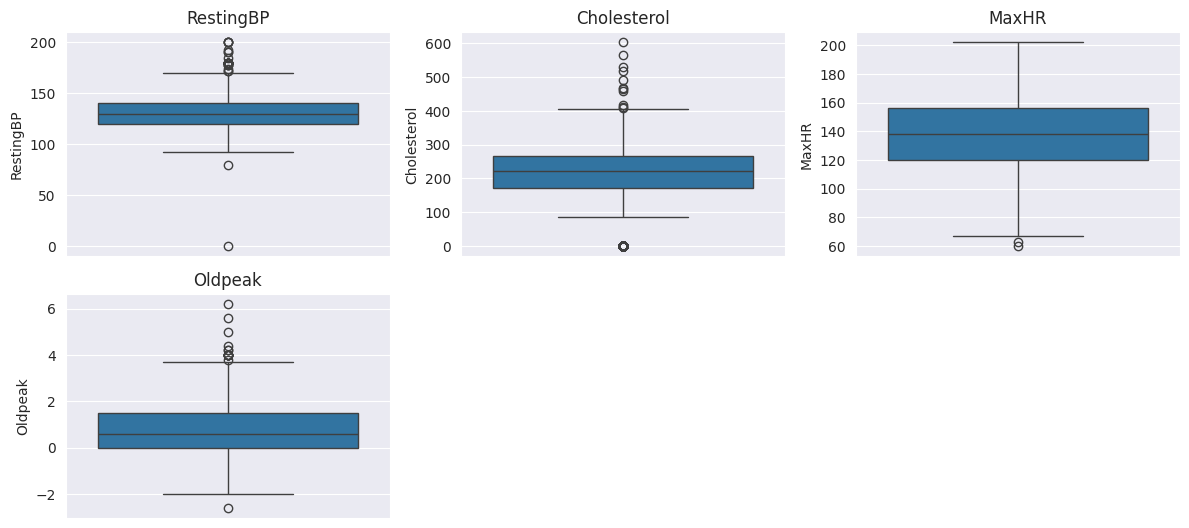

In [ ]:
print('Wykresy z wartosciamy odstajacymi przed scieciem wartosci odstajacych')
columns = ['RestingBP', 'Cholesterol','MaxHR','Oldpeak']
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [ ]:
remove_outliers_column(df, 'RestingBP')
remove_outliers_column(df, 'Cholesterol')
remove_outliers_column(df, 'MaxHR')
remove_outliers_column(df, 'Oldpeak')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264.0,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193.0,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131.0,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236.0,0,LVH,174,N,0.0,Flat,1


Wykresy z wartosciamy odstajacymi po scieciu wartosci odstajacych


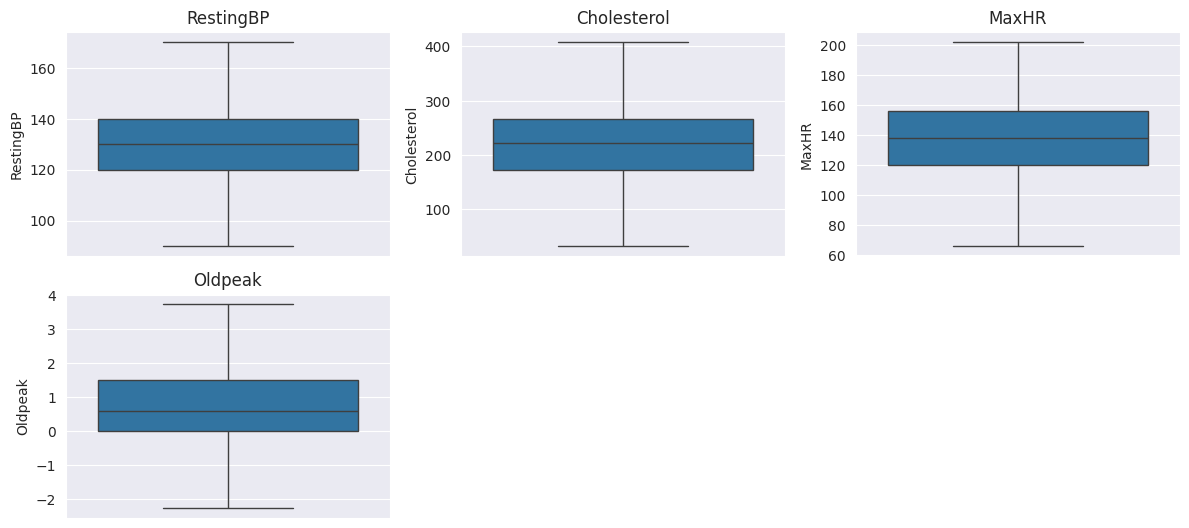

In [ ]:
print('Wykresy z wartosciamy odstajacymi po scieciu wartosci odstajacych')
columns = ['RestingBP', 'Cholesterol','MaxHR','Oldpeak']
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [ ]:
#rozbicie kolumn za pomocą get_dummies
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df = pd.get_dummies(df, columns=['ChestPainType'], drop_first=False)
df = pd.get_dummies(df, columns=['RestingECG'], drop_first=False)
df = pd.get_dummies(df, columns=['ExerciseAngina'], drop_first=True)
df = pd.get_dummies(df, columns=['ST_Slope'], drop_first=False)
# Sprawdzenie, jak wyglądają kolumny po przekształceniu
print(df.columns)

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')


In [ ]:
# Skalowanie zmiennych ciaglych
columns_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR','Oldpeak']
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
# Skalowanie zmiennych kategorycznych
label_encoder = LabelEncoder()

df['Sex_M'] = label_encoder.fit_transform(df['Sex_M'])
df['ChestPainType_ASY'] = label_encoder.fit_transform(df['ChestPainType_ASY'])
df['ChestPainType_ATA'] = label_encoder.fit_transform(df['ChestPainType_ATA'])
df['ChestPainType_NAP'] = label_encoder.fit_transform(df['ChestPainType_NAP'])
df['ChestPainType_TA'] = label_encoder.fit_transform(df['ChestPainType_TA'])
df['RestingECG_LVH'] = label_encoder.fit_transform(df['RestingECG_LVH'])
df['RestingECG_Normal'] = label_encoder.fit_transform(df['RestingECG_Normal'])
df['RestingECG_ST'] = label_encoder.fit_transform(df['RestingECG_ST'])
df['ExerciseAngina_Y'] = label_encoder.fit_transform(df['ExerciseAngina_Y'])
df['ST_Slope_Down'] = label_encoder.fit_transform(df['ST_Slope_Down'])
df['ST_Slope_Flat'] = label_encoder.fit_transform(df['ST_Slope_Flat'])
df['ST_Slope_Up'] = label_encoder.fit_transform(df['ST_Slope_Up'])

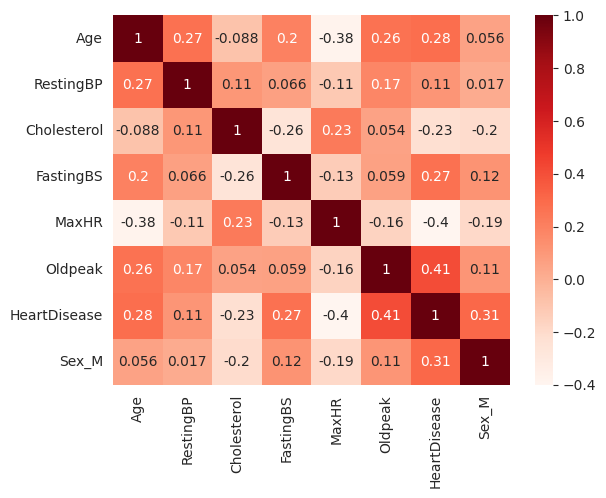

In [ ]:
# Macierz korelacji
corr_matrix = df.drop(['ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA','ChestPainType_ASY', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST','ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up'], axis=1).corr()

sns.heatmap(corr_matrix, annot=True, cmap='Reds')
plt.show()

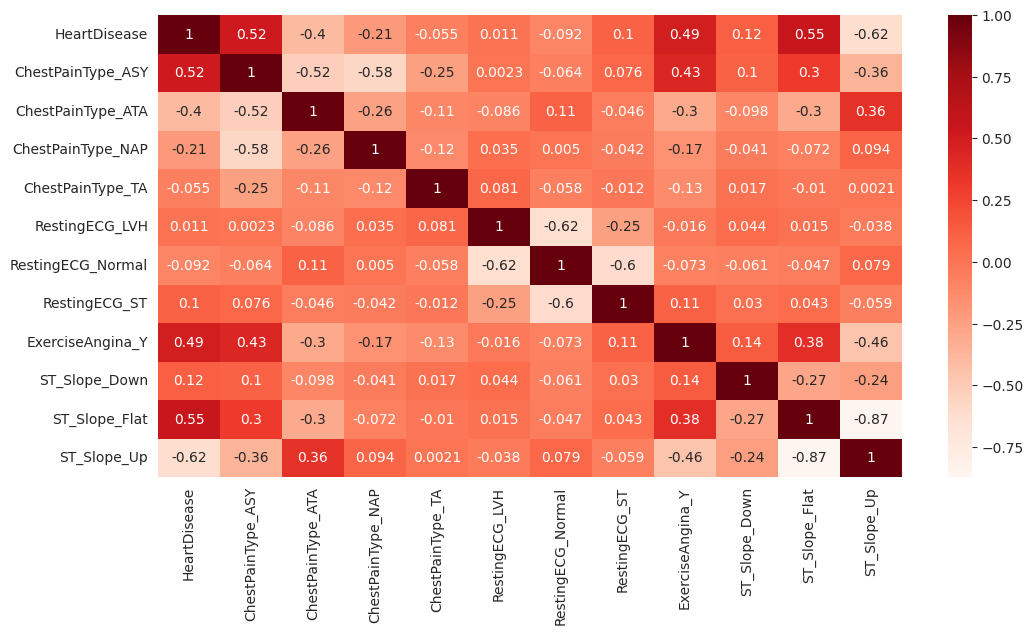

In [ ]:
corr_matrix = df.drop(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M'], axis=1).corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Reds')
plt.show()

In [ ]:
X = df.drop('HeartDisease', axis=1)
# Zmienna docelowa (y) - kolumna target
y = df['HeartDisease']
# Podział danych - 80% na trening, 20% na testy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Wypisujemy rozmiary danych
print(f"Rozmiar zbioru treningowego: {X_train.shape}")
print(f"Rozmiar zbioru testowego: {X_test.shape}")

Rozmiar zbioru treningowego: (734, 18)
Rozmiar zbioru testowego: (184, 18)


In [ ]:
# Tworzymy model KNN z 5 sąsiadami
knn_model = KNeighborsClassifier(n_neighbors=5)

# Dodanie wynikow do sekcji
update_results('KNN', knn_model, X_train, y_train, X_test, y_test)

# Trenowanie modelu na zestawie treningowym
knn_model.fit(X_train, y_train)

# Przewidywanie wyników na zbiorze testowym
y_pred = knn_model.predict(X_test)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)


# Ocena modelu za pomocą czułości (recall)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Wyświetlenie wyników
print('Model KNN')
print(f"Czułość: {recall:.2f}")
print(f"Dokładnosc: {accuracy:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")

Macierz pomyłek:
[[67 10]
 [14 93]]
Model KNN
Czułość: 0.87
Dokładnosc: 0.87
Precyzja: 0.90
Wskaźnik F1: 0.89


In [ ]:
# GaussianNB
gnb = GaussianNB()

# Trenowanie modelu na zbiorze treningowym
gnb.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = gnb.predict(X_test)

# Dodanie wynikow do sekcji
update_results('GausianNB', gnb, X_train, y_train, X_test, y_test)

# Ewaluacja modelu
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)

# Wyświetlenie wyników
print('Model GaussianNB')
print(f"Czułość: {recall:.2f}")
print(f"Dokładność: {accuracy:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")

Macierz pomyłek:
[[69  8]
 [17 90]]
Model GaussianNB
Czułość: 0.84
Dokładność: 0.86
Precyzja: 0.92
Wskaźnik F1: 0.88


In [ ]:
# Tworzenie modelu drzewa decyzyjnego
dtc = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)

# Dodanie wynikow do sekcji
update_results('DecisionTreeClassifier', dtc, X_train, y_train, X_test, y_test)

# Trenowanie modelu
dtc.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred = dtc.predict(X_test)

# Obliczenie metryk
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)

print('Model drzew decyzyjnych')
print(f"Dokładność: {accuracy:.2f}")
print(f"Czułość: {recall:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")

Macierz pomyłek:
[[66 11]
 [17 90]]
Model drzew decyzyjnych
Dokładność: 0.85
Czułość: 0.84
Precyzja: 0.89
Wskaźnik F1: 0.87


In [ ]:
# Tworzenie modelu drzew losowych
rf_clf = RandomForestClassifier(n_estimators=100,        # Liczba drzew w lesie
                                criterion='gini',        # Użycie Gini do podziału węzłów
                                max_depth=15,            # Maksymalna głębokość drzew
                                min_samples_split=5,     # Minimalna liczba próbek do podziału węzła
                                min_samples_leaf=2,      # Minimalna liczba próbek w liściu
                                max_features='sqrt',     # Liczba cech do rozważenia przy każdym podziale
                                random_state=42)
# Dodanie wynikow do sekcji
update_results('RandomForestClassifier', rf_clf, X_train, y_train, X_test, y_test)

# Trenowanie modelu
rf_clf.fit(X_train, y_train)

# Predykcje
y_pred = rf_clf.predict(X_test)

# Obliczanie metryk
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)

print('Model lasu drzew losowych')
print(f"Dokładność: {accuracy:.2f}")
print(f"Czułość: {recall:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")

Macierz pomyłek:
[[66 11]
 [13 94]]
Model lasu drzew losowych
Dokładność: 0.87
Czułość: 0.88
Precyzja: 0.90
Wskaźnik F1: 0.89


In [ ]:
# Tworzenie modelu regresji logistycznej z niestandardowymi hiperparametrami
log_reg = LogisticRegression(solver='liblinear', penalty='l2', C=1, max_iter=1000, random_state=42)

#Dodanie wynikow do sekcji
update_results('LogisticRegression', log_reg, X_train, y_train, X_test, y_test)

# Trenowanie modelu
log_reg.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = log_reg.predict(X_test)

# Obliczanie metryk
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)

print('Model regresji logistycznej')
print(f"Dokładność: {accuracy:.2f}")
print(f"Czułość: {recall:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")
print('\n')

Macierz pomyłek:
[[67 10]
 [15 92]]
Model regresji logistycznej
Dokładność: 0.86
Czułość: 0.86
Precyzja: 0.90
Wskaźnik F1: 0.88




In [ ]:
# Tworzenie modelu maszyny wektorów nośnych z wyznaczaniem prawdopodobieństw
svc_model = SVC(kernel='poly', C=2.0, probability=True, random_state=42)

#Dodanie wynikow do sekcji
update_results('SVC', svc_model, X_train, y_train, X_test, y_test)


# Trenowanie modelu
svc_model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = svc_model.predict(X_test)

# Obliczanie metryk
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)

print('Model SVC')
print(f"Dokładność: {accuracy:.2f}")
print(f"Czułość: {recall:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")

Macierz pomyłek:
[[65 12]
 [15 92]]
Model SVC
Dokładność: 0.85
Czułość: 0.86
Precyzja: 0.88
Wskaźnik F1: 0.87


In [ ]:
# XGBOOST

# Tworzenie modelu
ada_model = AdaBoostClassifier(n_estimators=50)
ada_model.fit(X_train, y_train)

#Dodanie wynikow do sekcji
update_results('AdaModel', ada_model, X_train, y_train, X_test, y_test)


y_pred = ada_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)

print('Model AdaBoost')
print(f'Dokładność: {accuracy:.2f}')
print(f"Czułość: {recall:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")

Macierz pomyłek:
[[68  9]
 [19 88]]
Model AdaBoost
Dokładność: 0.85
Czułość: 0.82
Precyzja: 0.91
Wskaźnik F1: 0.86


In [ ]:
# Extra Trees Classifier
et_model = ExtraTreesClassifier(n_estimators=250, random_state=42)
et_model.fit(X_train, y_train)

# Dodanie wynikow do sekcji
update_results('Et_model', et_model, X_train, y_train, X_test, y_test)

# Predykcja na zbiorze testowym
y_pred = et_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)

print('Model Extra Trees Classifier')
print(f'Dokładność: {accuracy:.2f}')
print(f"Czułość: {recall:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")

Macierz pomyłek:
[[68  9]
 [14 93]]
Model Extra Trees Classifier
Dokładność: 0.88
Czułość: 0.87
Precyzja: 0.91
Wskaźnik F1: 0.89


In [ ]:
# QDA

qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

# Dodanie wynikow do sekcji
update_results('qda_model', qda_model, X_train, y_train, X_test, y_test)

# Predykcja na zbiorze testowym
y_pred = qda_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)

print('Model QDA')
print(f'Dokładność: {accuracy:.2f}')
print(f"Czułość: {recall:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")
print('\n')

Macierz pomyłek:
[[57 20]
 [11 96]]
Model QDA
Dokładność: 0.83
Czułość: 0.90
Precyzja: 0.83
Wskaźnik F1: 0.86




/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# CatBoost
cat_model = CatBoostClassifier(
    iterations=100,          # liczba iteracji
    depth=5,                 # głębokość drzewa
    learning_rate=0.1,       # współczynnik uczenia się
    verbose=10               # częstotliwość wyświetlania informacji o procesie treningu
)

update_results('CatBoost', cat_model, X_train, y_train, X_test, y_test)

# Trenowanie modelu
cat_model.fit(X_train, y_train)

# Predykcja i ewaluacja
y_pred = cat_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:")
print(cm)

print('Model CatBoost')
print(f'Dokładność: {accuracy:.2f}')
print(f"Czułość: {recall:.2f}")
print(f"Precyzja: {precision:.2f}")
print(f"Wskaźnik F1: {f1:.2f}")

0:	learn: 0.6470607	total: 47.4ms	remaining: 4.7s
10:	learn: 0.4335111	total: 54.7ms	remaining: 443ms
20:	learn: 0.3571204	total: 62.1ms	remaining: 234ms
30:	learn: 0.3185089	total: 69.7ms	remaining: 155ms
40:	learn: 0.2947439	total: 78.4ms	remaining: 113ms
50:	learn: 0.2811788	total: 85.7ms	remaining: 82.3ms
60:	learn: 0.2681517	total: 93.7ms	remaining: 59.9ms
70:	learn: 0.2545458	total: 101ms	remaining: 41.4ms
80:	learn: 0.2447817	total: 109ms	remaining: 25.6ms
90:	learn: 0.2350356	total: 117ms	remaining: 11.5ms
99:	learn: 0.2270602	total: 124ms	remaining: 0us
0:	learn: 0.6470607	total: 586us	remaining: 58.1ms
10:	learn: 0.4335111	total: 7.74ms	remaining: 62.6ms
20:	learn: 0.3571204	total: 15.4ms	remaining: 58ms
30:	learn: 0.3185089	total: 23.1ms	remaining: 51.3ms
40:	learn: 0.2947439	total: 31.3ms	remaining: 45ms
50:	learn: 0.2811788	total: 39.1ms	remaining: 37.5ms
60:	learn: 0.2681517	total: 48.4ms	remaining: 30.9ms
70:	learn: 0.2545458	total: 56.3ms	remaining: 23ms
80:	learn: 0.24

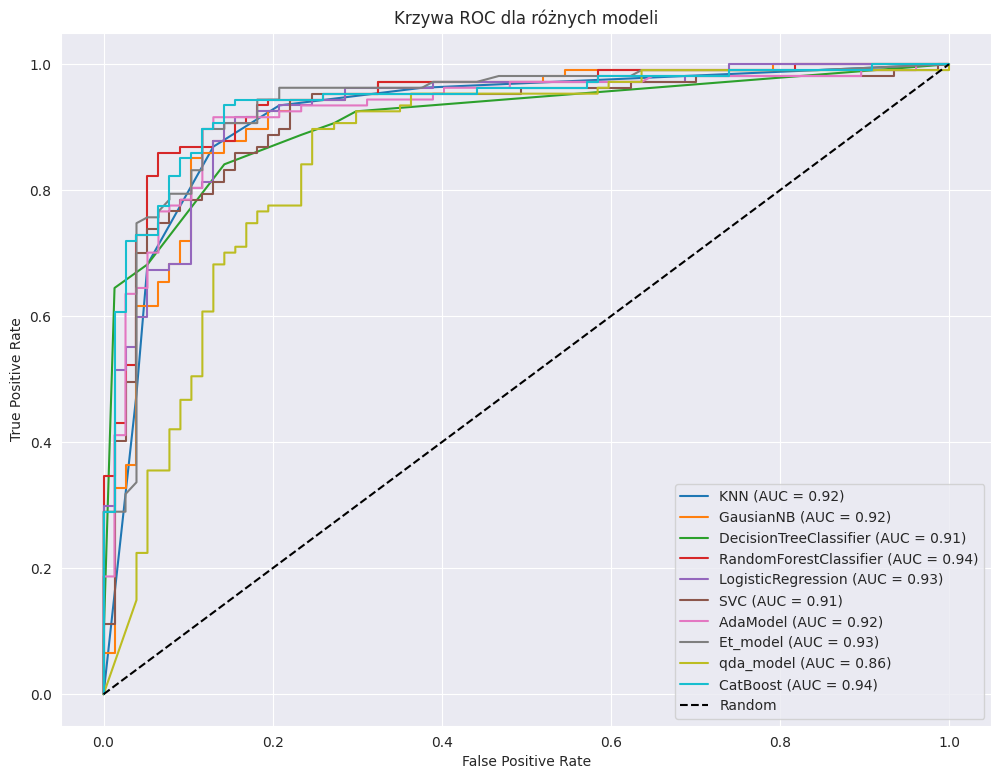

In [ ]:
#krzywa ROC
plt.figure(figsize=(12, 9))

for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})')

# Liniowa krzywa dla losowego klasyfikatora
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Tytuł i etykiety
plt.title('Krzywa ROC dla różnych modeli')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [ ]:
results_df = pd.DataFrame(metrics_results)
# Ranking na podstawie czułości
ranked_models_recall = results_df.sort_values(by='recall', ascending=False).reset_index(drop=True)
ranked_models_recall['Rank'] = ranked_models_recall.index + 1
print("\nRanking modeli na podstawie czułości (recall):")
print(ranked_models_recall[['Rank', 'model', 'recall']].to_string(index=False))

# Ranking na podstawie F1-score
ranked_models_f1 = results_df.sort_values(by='f1', ascending=False).reset_index(drop=True)
ranked_models_f1['Rank'] = ranked_models_f1.index + 1
print("\nRanking modeli na podstawie F1-score:")
print(ranked_models_f1[['Rank', 'model', 'f1']].to_string(index=False))

# Ranking na podstawie AUC
ranked_models_auc = results_df.sort_values(by='roc_auc', ascending=False).reset_index(drop=True)
ranked_models_auc['Rank'] = ranked_models_auc.index + 1
print("\nRanking modeli na podstawie AUC:")
print(ranked_models_auc[['Rank', 'model', 'roc_auc']].to_string(index=False))


Ranking modeli na podstawie czułości (recall):
 Rank                  model   recall
    1              qda_model 0.897196
    2               CatBoost 0.897196
    3 RandomForestClassifier 0.878505
    4                    KNN 0.869159
    5                    KNN 0.869159
    6               Et_model 0.869159
    7               Et_model 0.869159
    8     LogisticRegression 0.859813
    9                    SVC 0.859813
   10              GausianNB 0.841121
   11              GausianNB 0.841121
   12 DecisionTreeClassifier 0.841121
   13               AdaModel 0.822430

Ranking modeli na podstawie F1-score:
 Rank                  model       f1
    1               CatBoost 0.901408
    2               Et_model 0.889952
    3               Et_model 0.889952
    4 RandomForestClassifier 0.886792
    5                    KNN 0.885714
    6                    KNN 0.885714
    7     LogisticRegression 0.880383
    8              GausianNB 0.878049
    9              GausianNB 0.878049
 

**1. Ogólna skuteczność modeli w różnych metrykach**

*   CatBoost jest jednym z najlepszych modeli, zajmując wysokie pozycje w rankingu dla wszystkich metryk. Wyróżnia się jako pierwszy w F1-score i ma drugą pozycję w rankingu AUC oraz czułości. Jest to więc model, który dobrze balansuje między precyzją a czułością

*   RandomForestClassifier zajmuje pierwszą pozycję w rankingu AUC i wysoką pozycję w F1-score i czułości. Jest to wszechstronny model o dobrych wynikach, zwłaszcza w ocenie skuteczności klasyfikacji (AUC) i równoważeniu czułości oraz precyzji (F1)

*   Et_model (Extra Trees) regularnie osiąga wysokie wyniki w czułości i F1-score oraz zajmuje trzecie miejsce w AUC. Podobnie jak CatBoost i RandomForest, Extra Trees sprawdza się dobrze w równoważeniu między czułością a precyzją.

**2. Szczególne przypadki modeli i ich zastosowania**

*   qda_model osiąga najlepszą pozycję w czułości, ale wypada słabiej pod względem F1-score (dopiero 13. miejsce) i AUC (ostatnie miejsce). Wysoka czułość oznacza, że model jest dobry w minimalizowaniu fałszywych negatywów, co może być przydatne, jeśli kluczowe jest wykrycie wszystkich pozytywnych przypadków jak np test na covid

*   LogisticRegression utrzymuje dość stabilną pozycję w trzech rankingach, zajmując miejsca między 5. a 8. Jest więc wszechstronny, ale niekoniecznie najlepszy w żadnym aspekcie


*   K-Nearest Neighbors (KNN) jest jednym z lepiej ocenianych modeli w czułości i F1-score, ale jego wynik AUC plasuje go na niższej pozycji. KNN może być przydatny w kontekście, gdzie kluczowe jest zbalansowanie trafności wyników

**3. Ogólna stabilność wyników w zależności od metryki**



*   Modele takie jak CatBoost, RandomForestClassifier i Et_model wykazują stabilność między rankingami, co sugeruje ich ogólną przydatność w różnych warunkach

*   Modele jak qda_model i AdaModel mają bardziej specyficzne zastosowania – qda_model jest lepszy w wykrywaniu pozytywnych przypadków (czułość), ale AdaModel jest stabilniejszy pod kątem ogólnej skuteczności (AUC)

4. Dobór metryki do oceny modelu

*   Czułość (recall): Wysoka czułość jest kluczowa, jeśli projekt wymaga minimalizacji pominiętych przypadków pozytywnych (np. w wykrywaniu chorób, oszustw). W takim przypadku można rozważyć qda_model lub CatBoost

*   F1-score: F1-score jest przydatny, gdy klasy są niezrównoważone, a zależy nam na równoważeniu między precyzją i czułością. Tu CatBoost, Et_model i RandomForest mają najlepsze wyniki

*   AUC: Pomaga ocenić, jak dobrze model różnicuje klasy ogólnie, niezależnie od progu decyzyjnego. RandomForestClassifier i CatBoost mają tutaj najwyższe wyniki, więc są najlepsze pod względem ogólnej trafności



















